In [23]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import xarray as xr

import neuro_op as nop

In [24]:
nop.plot_setup()

In [25]:
# Define util functions


def get_name(N_nodes, nn, sd_llf, run=None):
    name = (
        "../testing/@MA1-FirstBuilder/output3/"
        + "out"
        + "-N"
        + str(N_nodes)
        + "-nn"
        + str(nn)
        + "-sd_llf"
        + str(sd_llf)
    )
    if run != None:
        name += "-run" + str(run)
    return name + ".h5"


def get_mu(a, b, c, d=None):
    data = nop.import_hdf5(get_name(a, b, c, d), samples=True)
    return data["mu_nodes"]


def get_sd(a, b, c, d=None):
    data = nop.import_hdf5(get_name(a, b, c, d), samples=True)
    return data["sd_nodes"]


def get_kld(a, b, c, d=None):
    data = nop.import_hdf5(get_name(a, b, c, d), samples=True)
    return data["kl_divs"]


# Analytical functions for conjugate pairs


def sd_N(sd0, sd_in, N):
    """Returns analytically obtained sd of Normal conjugate pair after N data points with sd=sd_in"""
    return (sd0**-2 + N * sd_in**-2) ** -0.5


def KLD_PPD(mu1, mu2, sd1, sd2):
    """Returns analytically obatined KLD of two univariate Normal distributions"""
    return np.log(sd2 / sd1) + (sd1**2 + (mu1 - mu2) ** 2) / (2 * sd2**2) - 1 / 2


def get_ls(sd_llf):
    ls = ""
    if sd_llf == 1:
        ls = "--"
    elif sd_llf < 1:
        ls = ":"
    else:
        ls = "-"
    return ls

In [26]:
# Define parameter ranges to be used in this analysis
N_nodes = 150
N_arr = [1, 2, 150]
nn_arr = [0, 1, 5, 10, 15, 20]
sd_llf_arr = np.round(np.arange(0.5, 3.1, 0.5), 1)
t_arr = np.arange(0, len(get_kld(1, 0, sd_llf_arr[-1])), 1, dtype=float)
t2_len = len(get_kld(2, 1, sd_llf_arr[-1]))
run_arr = np.arange(7)

In [27]:
# Initialize xarray Dataset
tmp_arr = np.empty(
    (len(N_arr), len(nn_arr), len(sd_llf_arr), len(t_arr), len(run_arr), N_nodes)
)
ds = xr.Dataset(
    {
        "mu": (("N", "nn", "sd_llf", "time", "run", "node"), np.empty_like(tmp_arr)),
        "sd": (("N", "nn", "sd_llf", "time", "run", "node"), np.empty_like(tmp_arr)),
        "kld": (("N", "nn", "sd_llf", "time", "run", "node"), np.empty_like(tmp_arr)),
    },
    coords={
        "N": N_arr,
        "nn": nn_arr,
        "sd_llf": sd_llf_arr,
        "run": run_arr,
        "time": t_arr,
        "node": np.arange(N_nodes),
    },
)
del tmp_arr

# Populate the Dataset
for N, sd_llf in itertools.product(N_arr, sd_llf_arr):
    if N == 1:
        nn = 0
        ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, run=0, node=np.arange(N_nodes))] = (
            get_mu(N, nn, sd_llf)
        )
        ds.sd.loc[dict(N=N, nn=nn, sd_llf=sd_llf, run=0, node=np.arange(N_nodes))] = (
            get_sd(N, nn, sd_llf)
        )
        ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, run=0, node=np.arange(N_nodes))] = (
            get_kld(N, nn, sd_llf)
        )
    elif N == 2:
        nn = 1
        ds.mu.loc[
            dict(
                N=N,
                nn=nn,
                sd_llf=sd_llf,
                run=0,
                node=np.arange(N_nodes),
                time=t_arr[:t2_len],
            )
        ] = get_mu(N, nn, sd_llf)
        ds.sd.loc[
            dict(
                N=N,
                nn=nn,
                sd_llf=sd_llf,
                run=0,
                node=np.arange(N_nodes),
                time=t_arr[:t2_len],
            )
        ] = get_sd(N, nn, sd_llf)
        ds.kld.loc[
            dict(
                N=N,
                nn=nn,
                sd_llf=sd_llf,
                run=0,
                node=np.arange(N_nodes),
                time=t_arr[:t2_len],
            )
        ] = get_kld(N, nn, sd_llf)
    else:
        for run, nn in itertools.product(run_arr, nn_arr[2:]):
            ds.mu.loc[
                dict(
                    N=N,
                    nn=nn,
                    sd_llf=sd_llf,
                    run=run,
                    node=np.arange(N_nodes),
                    time=t_arr[:t2_len],
                )
            ] = get_mu(N, nn, sd_llf, run)
            ds.sd.loc[
                dict(
                    N=N,
                    nn=nn,
                    sd_llf=sd_llf,
                    run=run,
                    node=np.arange(N_nodes),
                    time=t_arr[:t2_len],
                )
            ] = get_sd(N, nn, sd_llf, run)
            ds.kld.loc[
                dict(
                    N=N,
                    nn=nn,
                    sd_llf=sd_llf,
                    run=run,
                    node=np.arange(N_nodes),
                    time=t_arr[:t2_len],
                )
            ] = get_kld(N, nn, sd_llf, run)
ds

<xarray.Dataset> Size: 27GB
Dimensions:  (N: 3, nn: 6, sd_llf: 6, time: 10001, run: 7, node: 150)
Coordinates:
  * N        (N) int64 24B 1 2 150
  * nn       (nn) int64 48B 0 1 5 10 15 20
  * sd_llf   (sd_llf) float64 48B 0.5 1.0 1.5 2.0 2.5 3.0
  * run      (run) int64 56B 0 1 2 3 4 5 6
  * time     (time) float64 80kB 0.0 1.0 2.0 3.0 ... 9.998e+03 9.999e+03 1e+04
  * node     (node) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    mu       (N, nn, sd_llf, time, run, node) float64 9GB 0.0 0.0 ... 0.0 0.0
    sd       (N, nn, sd_llf, time, run, node) float64 9GB 10.5 10.5 ... 0.0 0.0
    kld      (N, nn, sd_llf, time, run, node) float64 9GB 1.856 1.856 ... 0.0

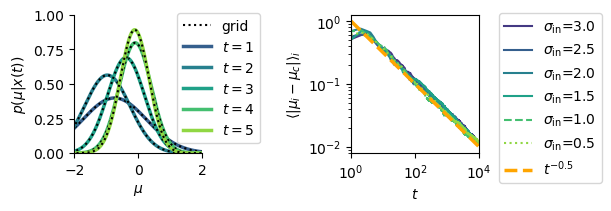

In [28]:
# Class-Consistency plot (reproduction)

# Define starting environment
seed = 112571560740682987948487732505763
nop.init_seeds(seed)

mu_prior, sd_prior = 1, 100
mu_arr = np.linspace(-4, 4, 1000)
world_data = st.norm.rvs(loc=0, scale=1, size=5)

# Initiate nodes and samples
node_g = nop.NodeGridMu(
    node_id=0,
    log_priors=st.norm.logpdf(x=mu_arr, loc=mu_prior, scale=sd_prior),
)
node_c = nop.NodeConjMu(
    node_id=1,
    params_node=dict(loc=mu_prior, scale=sd_prior),
)
g_samples = []
for i, x in enumerate(world_data):
    node_g.set_updated_belief(st.norm, mu_arr, 1, x, -1, i)
    g_samples += [node_g.log_probs.copy()]
    node_c.set_updated_belief(x, -1, i)
g_samples = np.array(g_samples)

mu_p_arr, sd_p_arr = nop.postrun_Mu_ConjMu(mu_prior, sd_prior, 1, node_c.diary_in)
p_samples = np.zeros_like(g_samples)
for i, params in enumerate(zip(mu_p_arr, sd_p_arr)):
    p_samples[i] = st.norm.logpdf(mu_arr, loc=params[0], scale=params[1])

# Figure set-up
x, y = (2, 1)
c = 2
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))
cmap = nop.get_colorcycle(len(g_samples))

i = 0
ax[i].set_prop_cycle(
    color=nop.get_colorcycle(len(g_samples) + 1)[1:],
)
ax[i].plot(0, 0, c="black", lw=1.5, ls=":", label="grid")

for k, y in enumerate(zip(g_samples, p_samples)):
    ax[i].plot(mu_arr, np.exp(y[1]), lw=2.5, label=f"$t=${k+1}")
    ax[i].plot(
        mu_arr,
        np.exp(y[0]) * np.max(np.exp(y[1])),
        c="black",
        ls=":",
        lw=1.5,
    ),
ax[i].set_xlabel("$\mu$")
ax[i].set_ylabel("$p(\mu | x(t))$")
ax[i].set_xlim(-2, 2)
ax[i].set_ylim(0, 1)
ax[0].spines[["right", "top"]].set_visible(False)
ax[i].legend(loc=2, bbox_to_anchor=(0.75, 1.06))

# ----------------------------------------------------------------------
# <|mu_i-mu_c|>
# Params of interest
sd_arr = ds.sd_llf.values[::-1]
time = ds.time.values
# Plot prep.
i = 1
colors = nop.get_colorcycle(N_colors=len(sd_arr))
ax[i].set_prop_cycle(color=colors)
ax[i].set_xlim((time[1], time[-1]))
ax[i].set_xscale("log")
ax[i].set_yscale("log")

# Plotting...
for sd_llf in sd_arr:
    # <|mu_i-mu_C|>
    ax[i].plot(
        time,
        np.abs(
            ds.mu.sel(
                N=1, nn=0, sd_llf=sd_llf, run=0, time=time, node=np.arange(N_nodes)
            )
        ).mean(
            dim="node",
        ),
        ls=get_ls(sd_llf),
        label="$\sigma_\\text{in}$=" + str(sd_llf),
    )
(line1,) = ax[1].plot(
    time[1:],
    time[1:] ** -(1 / 2),
    color="orange",
    ls="--",
    lw=2.5,
    label="$t^{-0.5}$",
)
# Title, label, ...
ax[i].set_xlabel("$t$")
ax[i].set_ylabel("\n$\langle |\mu_i-\mu_c|\\rangle_i$")
ax[i].legend(bbox_to_anchor=(1.1, 1.06), loc=2)

In [29]:
# fig.savefig("./fig/N1-Consistency--Delta.pdf")

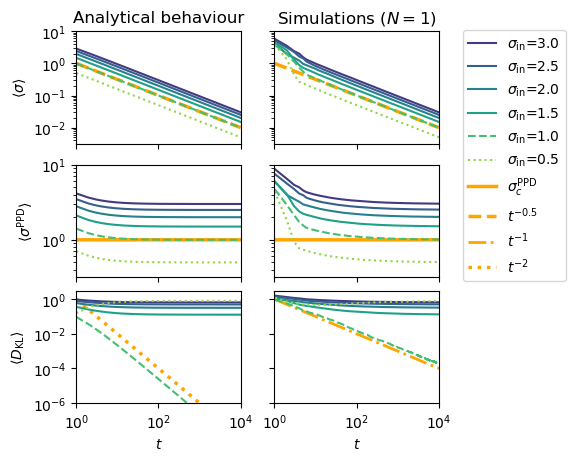

In [30]:
# Analysis vs. N=1
sd_arr = ds.sd_llf.values[::-1]  # Reverse to have line stacking match label stacking
sd0 = 10  # For analytical results, use the same prior as for simulations
sd_C = 1  # Central node PPD's sd
time = ds.time.values
x = 2
y = 3
c = 1.5
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, c * y))
colors = nop.get_colorcycle(N_colors=len(sd_arr))
for i, j in itertools.product(np.arange(y), np.arange(x)):
    ax[i, j].set_prop_cycle(color=colors)
    ax[i, j].set_xlim((time[1], time[-1]))
    ax[i, j].set_xscale("log")
    ax[i, j].set_yscale("log")

# Preparation: Add line to-be-modelled PPD sd (aka. sd_PPD=1); set colorcycles
label05 = "$t^{-0.5}$"
label0 = "$\sigma^\\text{PPD}_{c}$"
label1 = "$t^{-1}$"
label2 = ("$t^{-2}$",)
for j in range(x):
    (line0,) = ax[1, j].plot(
        time[1:],
        np.ones(len(time[1:])) * sd_C,
        color="orange",
        lw=2.5,
        label=label0,
    )
    (line05,) = ax[0, j].plot(
        time[1:],
        time[1:] ** -0.5,
        color="orange",
        ls="--",
        lw=2.5,
        label=label05,
    )
(line2,) = ax[2, 0].plot(
    time[1:],
    time[1:] ** -2,
    color="orange",
    ls=":",
    lw=2.5,
    label=label2,
)
(line1,) = ax[2, 1].plot(
    time[1:],
    time[1:] ** -1,
    color="orange",
    ls="-.",
    lw=2,
    label=label1,
)

# Plot analytical results...
j = 0
lines = []
for sd_in in sd_arr:
    # sd_N(N)
    sd = sd_N(sd0, sd_in, time)
    ax[0, j].plot(
        time,
        sd,
        ls=get_ls(sd_in),
    )
    ax[0, j].set_ylabel("$\langle\sigma\\rangle$")
    # sd_PPD(N)
    sd_PPD = (sd**2 + sd_in**2) ** 0.5
    ax[1, j].plot(
        time,
        sd_PPD,
        ls=get_ls(sd_in),
    )
    ax[1, j].set_ylabel("$\langle \sigma^\\text{PPD} \\rangle$")
    # KLD_PPD(N), given same means and sd_P=1
    (line_tmp,) = ax[2, j].plot(
        time,
        np.log(sd_PPD / sd_C) + sd_C**2 / (2 * sd_PPD**2) - 1 / 2,
        ls=get_ls(sd_in),
        label="$\sigma_\\text{in}$=" + str(sd_in),
    )
    lines.append(line_tmp)
    ax[2, j].set_ylabel("$\langle D_\\text{KL} \\rangle$")

# Data plots
# N=1, nn=0
j = 1
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    ax[i, j].plot(
        time,
        (
            ds.sd.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes))
            - sd_llf
        ).mean(
            dim="node",
        ),
        ls=get_ls(sd_llf),
    )
    # <sd^PPD_i>
    i = 1
    ax[i, j].plot(
        time,
        ds.sd.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes)).mean(
            dim="node"
        ),
        ls=get_ls(sd_llf),
    )
    # <D_KL(PPD_C||PPD_i)>
    i = 2
    ax[i, j].plot(
        time,
        ds.kld.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes)).mean(
            dim="node"
        ),
        ls=get_ls(sd_llf),
    )

# Labelling & stuffs...
# ylims
for j in range(x):
    ax[0, j].set_ylim(10**-2.5, 10**1)
    ax[0, j].xaxis.set_tick_params(labelbottom=False)
    ax[1, j].set_ylim(10**-0.5, 10**1)
    ax[1, j].xaxis.set_tick_params(labelbottom=False)
    ax[2, j].set_ylim(10**-6, 10**0.5)
    ax[y - 1, j].set_xlabel("$t$")
for i in range(y):
    ax[i, 1].yaxis.set_tick_params(labelleft=False)

# Analytical
j = 0
ax[0, j].set_title("Analytical behaviour")
# Simulation N=1
j = 1
ax[0, j].set_title("Simulations $(N=1)$")

fig.legend(
    handles=lines + [line0, line05, line1, line2],
    bbox_to_anchor=(1, 0.96),
    loc=2,
)

In [31]:
# fig.savefig("fig/@MA1-N1.pdf")

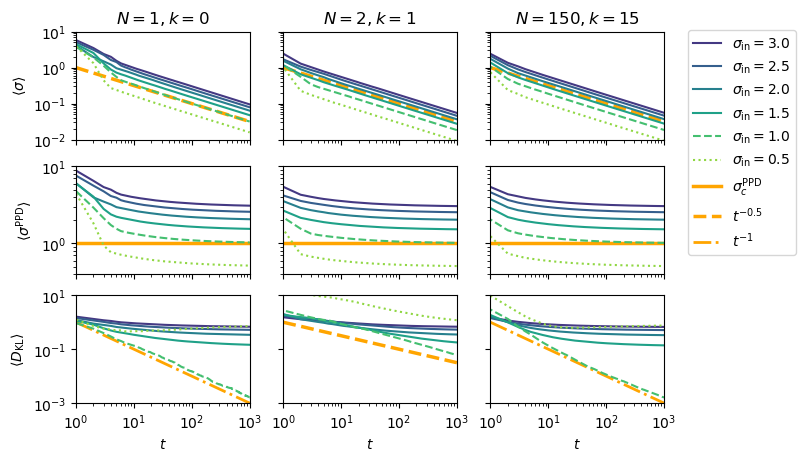

In [32]:
# N=1,2,150
sd_arr = ds.sd_llf.values[::-1]  # Reverse to have line stacking match label stacking
sd0 = 10  # For analytical results, use the same prior as for simulations
sd_C = 1  # Central node PPD's sd
time = ds.time.values
t2_len = len(get_kld(2, 1, sd_llf_arr[-1]))
time = time[:t2_len]
run_arr = np.arange(7)
# Figure set-up...
x = 3
y = 3
c = 1.5
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))
colors = nop.get_colorcycle(N_colors=len(sd_arr))
for i, j in itertools.product(np.arange(y), np.arange(x)):
    ax[i, j].set_prop_cycle(color=colors)
    ax[i, j].set_xlim((time[1], time[-1]))
    ax[i, j].set_xscale("log")
    ax[i, j].set_yscale("log")

# Preparation: Add line to-be-modelled PPD sd (aka. sd_PPD=1); set colorcycles
label05 = "$t^{-0.5}$"
label0 = "$\sigma^\\text{PPD}_{c}$"
label1 = "$t^{-1}$"
for j in range(x):
    (line0,) = ax[1, j].plot(
        time[1:],
        np.ones(t2_len - 1) * sd_C,
        color="orange",
        ls="-",
        lw=2.5,
        label=label0,
    )
    (line05,) = ax[0, j].plot(
        time[1:],
        time[1:] ** -0.5,
        color="orange",
        ls="--",
        lw=2.5,
        label=label05,
    )
    if j != 1:
        (line1,) = ax[2, j].plot(
            time[1:],
            time[1:] ** -1,
            color="orange",
            ls="-.",
            lw=2,
            label=label1,
        )
    else:
        ax[2, j].plot(
            time[1:],
            time[1:] ** -0.5,
            lw=2.5,
            color="orange",
            ls="--",
            label=label05,
        )

# Data plots
# N=1, nn=0
j = 0
lines = []
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    ax[i, j].set_ylabel("$\langle\sigma\\rangle$")
    (line_tmp,) = ax[i, j].plot(
        time,
        (
            ds.sd.sel(
                N=1, nn=0, sd_llf=sd_llf, run=0, time=time, node=np.arange(N_nodes)
            )
            - sd_llf
        ).mean(
            dim="node",
        ),
        ls=get_ls(sd_llf),
        label="$\sigma_\\text{in}=$" + str(sd_llf),
    )
    lines.append(line_tmp)
    # <sd^PPD_i>
    i = 1
    ax[i, j].set_ylabel("$\langle \sigma^\\text{PPD} \\rangle$")
    ax[i, j].plot(
        time,
        ds.sd.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes)).mean(
            dim="node"
        ),
        ls=get_ls(sd_llf),
    )
    # <D_KL(PPD_C||PPD_i)>
    i = 2
    ax[i, j].set_ylabel("$\langle D_\\text{KL} \\rangle$")
    ax[i, j].plot(
        time,
        ds.kld.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes)).mean(
            dim="node"
        ),
        ls=get_ls(sd_llf),
    )
# N=2, nn=1
j = 1
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    ax[i, j].plot(
        time[:t2_len],
        (
            ds.sd.sel(
                N=2, nn=1, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
            )
            - sd_llf
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    # <sd^PPD_i>
    i = 1
    ax[i, j].plot(
        time[:t2_len],
        ds.sd.sel(
            N=2, nn=1, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    # <KLD_i>
    i = 2
    ax[i, j].plot(
        time[:t2_len],
        ds.kld.sel(
            N=2, nn=1, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
# N=150, nn=5
j = 2
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    nn = 15
    ax[i, j].plot(
        time[:t2_len],
        (
            ds.sd.sel(
                N=150, nn=nn, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
            )
            - sd_llf
        )
        .mean(dim="node")
        .mean(dim="run"),
        label="",
        ls=get_ls(sd_llf),
    )
    # <sd^PPD_i>
    i = 1
    ax[i, j].plot(
        time[:t2_len],
        ds.sd.sel(
            N=150,
            nn=nn,
            sd_llf=sd_llf,
            run=run_arr,
            time=time[:t2_len],
            node=np.arange(N_nodes),
        )
        .mean(dim="node")
        .mean(dim="run"),
        label="",
        ls=get_ls(sd_llf),
    )
    # <KLD_i>
    i = 2
    ax[i, j].plot(
        time[:t2_len],
        ds.kld.sel(
            N=150, nn=nn, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
        )
        .mean(dim="node")
        .mean(dim="run"),
        label="",
        ls=get_ls(sd_llf),
    )

# Labelling & stuffs...
j = 0
ax[0, j].set_title("$N=1, k=0$")
j = 1
ax[0, j].set_title("$N=2, k=1$")
j = 2
ax[0, j].set_title("$N=150, k=15$")
for j in range(x):
    ax[0, j].set_ylim(10**-2, 10**1)
    ax[1, j].set_ylim(10**-0.4, 10**1)
    ax[2, j].set_ylim(10**-3, 10**1)
    ax[y - 1, j].set_xlabel("$t$")
    ax[0, j].xaxis.set_tick_params(labelbottom=False)
    ax[1, j].xaxis.set_tick_params(labelbottom=False)
    if j != 0:
        for i in range(y):
            ax[i, j].yaxis.set_tick_params(labelleft=False)

fig.legend(
    handles=lines + [line0, line05, line1],
    bbox_to_anchor=(1, 0.96),
    loc=2,
)

In [33]:
# fig.savefig("./fig/@MA1-0N1N2.pdf")